#Training 

##Import Modules 

In [1]:
import numpy
import cv2
import scipy.linalg
from google.colab.patches import cv2_imshow
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from random import randint
import torch.nn.functional as F 
import random
from google.colab import drive
from scipy.linalg import sqrtm 
drive.mount('/content/drive')

Mounted at /content/drive


##Loading Unordered data 

In [2]:
df = pd.read_csv('/content/drive/MyDrive/intelligent_font_files/CSV_files/mygdatasheet12.csv')
df.drop(df.columns[[0]], axis = 1, inplace = True)
print(df)

      previous alphabet current alphabet next alphabet  \
0                     e                c             t   
1                     h                e             n   
2                                      y             o   
3                     w                e             a   
4                                      t             h   
...                 ...              ...           ...   
12547                 f                o             r   
12548                 w                o             u   
12549                 w                h             o   
12550                                  d             a   
12551                                  p             r   

                                     spacial information  \
0                     [[21, 35], [1200.875, 569.390625]]   
1      [[16, 11], [932.171052631579, 236.3421052631579]]   
2      [[7, 23], [439.9656862745098, 432.3480392156863]]   
3      [[21, 37], [1199.2894736842106, 622.1315789473...   
4  

##HyperParameters 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 1
IMG_SIZE = 64
CHANNELS_IMG = 1
NUM_CLASSES = 26
GEN_EMBEDDING = 100 
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

##Discriminator 

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size 
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding (num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim = 1)
        return self.disc(x)

##Generator 

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size 
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+ embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim = 1)
        return self.net(x)

##Initialize weights 

In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

##Gradient Panality

In [7]:
def gradient_penalty(critic,labels,  real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

##Initialization

In [8]:
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()


Discriminator(
  (disc): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
  (embed): Embedding(26, 4096

##Utility Functions 

In [9]:

NOISE_DIM = Z_DIM

def noisetensor(a,b,c):
    noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
    for i in range(NOISE_DIM): 
      if i < 0.2 * NOISE_DIM: 
        noise[0][i][0][0] = a
      if i < 0.8 * NOISE_DIM and i>= 0.2*NOISE_DIM: 
        noise[0][i][0][0] = b
      if i < NOISE_DIM and i >= 0.8 * NOISE_DIM : 
        noise[0][i][0][0] = c
    return noise


def noisetensorbasic(b):
    noise = torch.randn(1, 100, 1, 1).to(device)
    for i in range(Z_DIM):
      noise[0][i][0][0] = b-97
    return noise

def normalize(myarr):
  for i in range(len(myarr)): 
    for j in range(len(myarr[0])): 
        # myarr[i][j] =  ((myarr[i][j] + 1) * 255)/2
        myarr[i][j] =  ((myarr[i][j] *2)/255) -1 
  return myarr



def denormalize(myarr):
  for i in range(len(myarr)): 
    for j in range(len(myarr[0])): 
        myarr[i][j] =  ((myarr[i][j] + 1) * 255)/2
  return myarr


def gettensorinput(arr): 
        arr1 = arr
        arr1 = normalize(arr)
        real = torch.tensor(arr1).to(device)
        real =torch.unsqueeze(real, 0)
        real = torch.unsqueeze(real, 0)   
        real = real.type(torch.cuda.FloatTensor)
        return real


def getlabel(n): 
        number = ord(df.iloc[n][1]) -97
        a_list = [number]
        a_tensor = torch.Tensor(a_list)
        a_tensor.to(device)
        labels = a_tensor.type(torch.cuda.LongTensor)
        return labels 

def getnumpyout(tensor): 
  res = torch.squeeze(tensor, 0)
  res1 = torch.squeeze(res, 0)
  resnp = res1.cpu().detach().numpy()
  resfi = denormalize(resnp)
  return resfi


def getlabel1(n): 
        number = n -97
        a_list = [number]
        a_tensor = torch.Tensor(a_list)
        a_tensor.to(device)
        labels = a_tensor.type(torch.cuda.LongTensor)
        return labels 

print(getlabel1(97))

tensor([0], device='cuda:0')


##Training 

----------
epoch is : 0 iteration is 0
original handwritten character


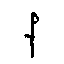

Artificial intelligence replicating my character


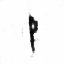

---------------------------------------------------------
----------
epoch is : 0 iteration is 1000
original handwritten character


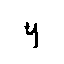

Artificial intelligence replicating my character


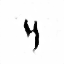

---------------------------------------------------------
----------
epoch is : 0 iteration is 2000
original handwritten character


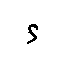

Artificial intelligence replicating my character


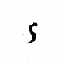

---------------------------------------------------------
----------
epoch is : 0 iteration is 3000
original handwritten character


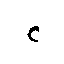

Artificial intelligence replicating my character


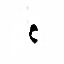

---------------------------------------------------------
----------
epoch is : 0 iteration is 4000
original handwritten character


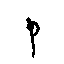

Artificial intelligence replicating my character


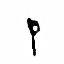

---------------------------------------------------------
----------
epoch is : 0 iteration is 5000
original handwritten character


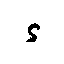

Artificial intelligence replicating my character


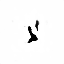

---------------------------------------------------------
----------
epoch is : 0 iteration is 6000
original handwritten character


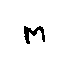

Artificial intelligence replicating my character


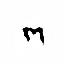

---------------------------------------------------------
----------
epoch is : 0 iteration is 7000
original handwritten character


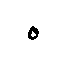

Artificial intelligence replicating my character


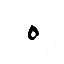

---------------------------------------------------------
----------
epoch is : 0 iteration is 8000
original handwritten character


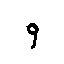

Artificial intelligence replicating my character


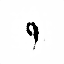

---------------------------------------------------------
----------
epoch is : 0 iteration is 9000
original handwritten character


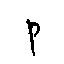

Artificial intelligence replicating my character


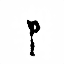

---------------------------------------------------------
----------
epoch is : 0 iteration is 10000
original handwritten character


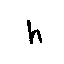

Artificial intelligence replicating my character


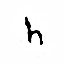

---------------------------------------------------------
----------
epoch is : 0 iteration is 11000
original handwritten character


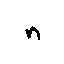

Artificial intelligence replicating my character


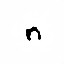

---------------------------------------------------------
----------
epoch is : 0 iteration is 12000
original handwritten character


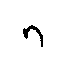

Artificial intelligence replicating my character


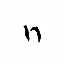

---------------------------------------------------------


In [ ]:
for epoch in range(1):

    state = {
    'gen': gen.state_dict(),
    'critic': critic.state_dict(),
    'opt_gen': opt_gen.state_dict(),
    'opt_critic': opt_critic.state_dict(),
        }
    # file_name = '/content/drive/MyDrive/trained_models/noise_model' + str(epoch) + '.pth.tar'
    # print(file_name)
    # torch.save(state, file_name)
    # Target labels not needed! <3 unsupervised
    for i in range(len(df)):
        real = gettensorinput(eval(df.iloc[i][4]))
        labels = getlabel(i)
        for _ in range(CRITIC_ITERATIONS):
            # noise = noisetensorbasic(ord(df.iloc[i][1])).to(device)
            noise = torch.randn(1, Z_DIM, 1, 1).to(device)
            fake = gen(noise,labels )
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic,labels,  real, fake, device=device)
            loss_critic = (     
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    
        if i % 1000 == 0:

   
          print('----------')

          noise = noisetensorbasic(ord(df.iloc[i][1])).to(device)
          # print('loss of disc is : ' + str(loss_critic) + 'loss of gen is: ' + str(loss_gen))

          print('epoch is : ' + str(epoch) + ' iteration is '+ str(i))
          
          lis = eval(df.iloc[i][4])
          nparr = numpy.asarray(lis)
          print('original handwritten character')
          cv2_imshow(nparr)  



          labels = getlabel1(ord(df.iloc[i][1]))
          noise = torch.randn(1, Z_DIM, 1, 1).to(device)
          res = gen(noise, labels)
          resnp = getnumpyout(res)
          print('Artificial intelligence replicating my character')
          cv2_imshow(resnp)  
          print('---------------------------------------------------------')




#DEMO

##Loading Ordered data frame 

In [10]:
df = pd.read_csv('/content/drive/MyDrive/intelligent_font_files/CSV_files/mygdatasheet12_ordered_data.csv')
df.drop(df.columns[[0]], axis = 1, inplace = True)
print(df)

      previous alphabet current alphabet next alphabet  \
0                                      f             o   
1                     f                o             l   
2                     o                l             l   
3                     l                l             o   
4                     l                o             w   
...                 ...              ...           ...   
12001                                  f             u   
12002                 f                u             t   
12003                 u                t             r   
12004                 t                r             e   
12005                 r                e                 

                                     spacial information  \
0                    [[0, 0], [39.14141414141414, 67.0]]   
1       [[0, 1], [44.83673469387755, 84.26530612244898]]   
2      [[0, 2], [40.78666666666667, 100.57333333333334]]   
3      [[0, 3], [44.61971830985915, 110.21126760563381]]   
4  

##Loading Trained Models 

In [11]:
state = torch.load('/content/drive/MyDrive/intelligent_font_files/all_trained_models/rcdcgan/rcdcgan_epoch30.pth.tar')

model =  Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING)
model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
model.to(device)

model1 = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE)
model1.load_state_dict(state['critic'])  # Choose whatever GPU device number you want
model1.to(device)

opt_gen1 = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_gen1.load_state_dict(state['opt_gen'])
opt_critic1.load_state_dict(state['opt_critic'])

##Character Generation 

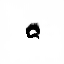

[[253.37660217285156,
  254.62583923339844,
  254.97328186035156,
  254.8957061767578,
  254.98104858398438,
  254.80682373046875,
  254.97860717773438,
  254.89173889160156,
  254.9810333251953,
  254.79759216308594,
  254.97720336914062,
  254.8701171875,
  254.97250366210938,
  254.7262420654297,
  254.9659423828125,
  254.84205627441406,
  254.96969604492188,
  254.72705078125,
  254.9678955078125,
  254.8522491455078,
  254.9730987548828,
  254.75405883789062,
  254.9697723388672,
  254.8441619873047,
  254.9664764404297,
  254.70230102539062,
  254.96475219726562,
  254.84397888183594,
  254.972900390625,
  254.78182983398438,
  254.97897338867188,
  254.89967346191406,
  254.9823760986328,
  254.815185546875,
  254.9810791015625,
  254.903564453125,
  254.98336791992188,
  254.823974609375,
  254.98162841796875,
  254.90426635742188,
  254.9832305908203,
  254.8155059814453,
  254.97958374023438,
  254.88783264160156,
  254.9787139892578,
  254.7906494140625,
  254.9773254394531

In [12]:
def demo(model, character): 
  labels = getlabel1(ord(character))
  # noise = noisetensorbasic(ord(character)).to(device)
  noise = torch.randn(1, Z_DIM, 1, 1).to(device)
  res = model(noise, labels)
  resnp = getnumpyout(res)
  cv2_imshow(resnp) 
  resnp = resnp.tolist()
  return resnp

demo(model, 'a')

##Utility Files 

In [13]:
from torch._C import NoneType
from statistics import mean
def getdisplacement (df, charac1, charac2): 
  # print(type(charac1))
  instances = 0
  rowdifflist = [0]
  rowdifflist2 = [0]
  coldifflist = [13]
  for i in range(len(df)):
    if df.iloc[i][0] == charac1 and df.iloc[i][1] == charac2  : 
      listt1 = eval(df.iloc[i-1][3])
      listt2 = eval(df.iloc[i][3])
      if listt1[0][0] == listt2[0][0]:
        instances = instances +1
      
        coldifflist.append(listt2[1][1] - listt1[1][1])
        rowdifflist2.append(listt2[1][0]- listt1[1][0])
  return [mean(rowdifflist2), mean(coldifflist), instances]

print(getdisplacement(df, 'f', 'o'))



def getset(res, m, n): 
  sett = set()
  for i in range(64): 
    for j in range(64): 
      if res[i][j] < 180: 
        sett.add((i+m,j+n))
  return sett




[5.454425069859305, 14.694619990386228, 48]


##Final Demo

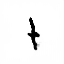

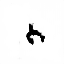

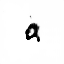

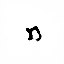

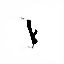

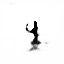

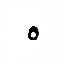

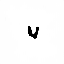

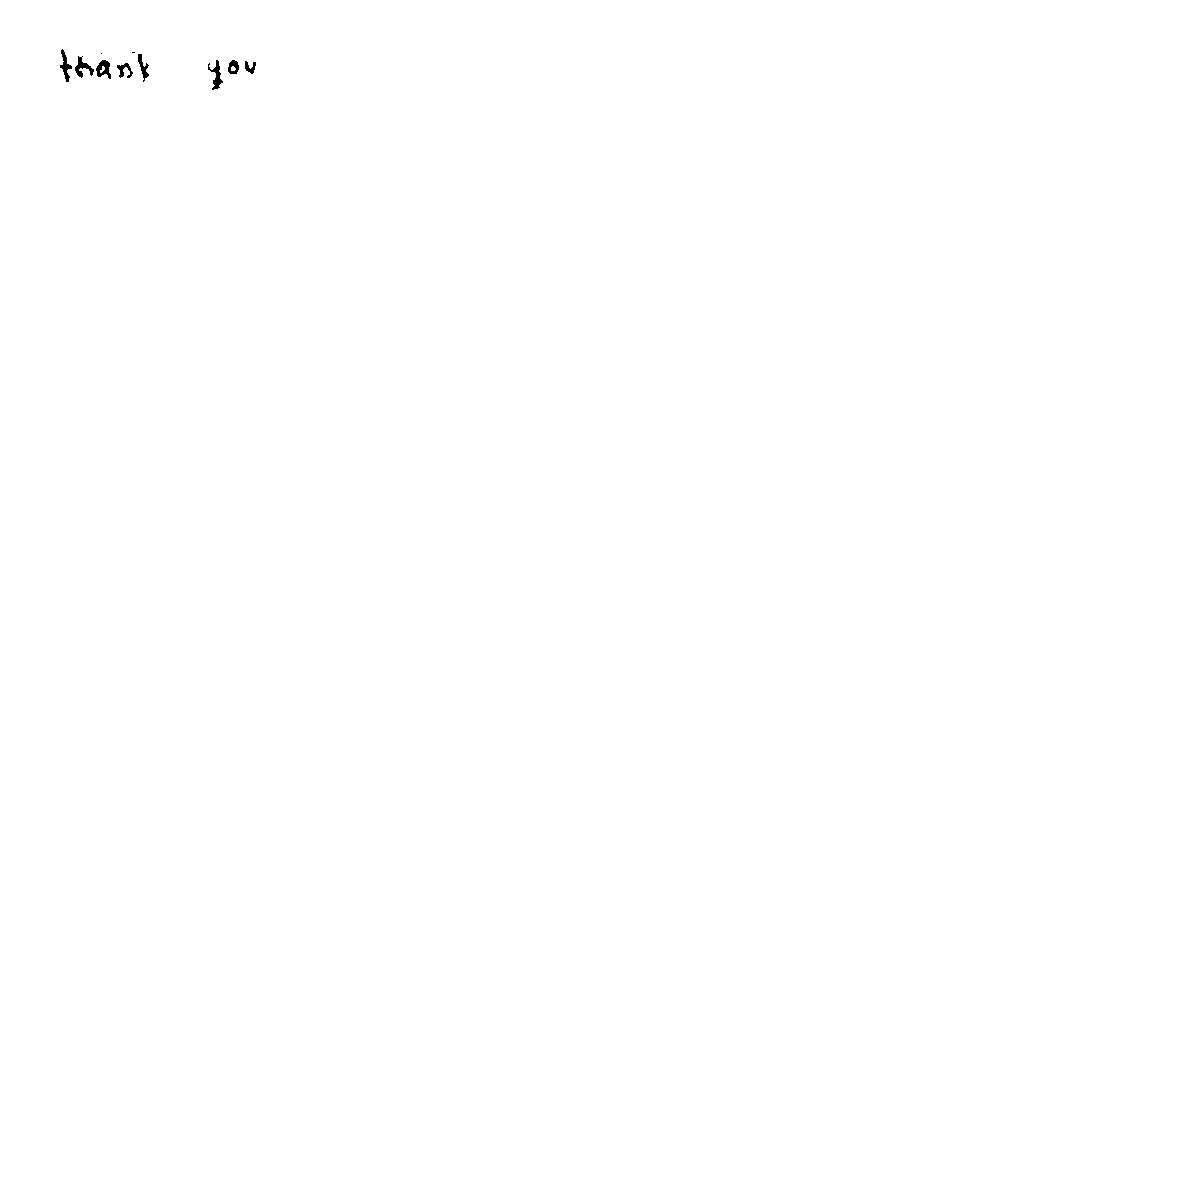

In [16]:
def ShowMeTheDemo(df, model, string, row, col): 
  whole = [[255 for i in range(col)] for j in range(row)]
  n = len(string)
  cur_center = [32, 32]
  current_displacement = [0, 0]
  res =   demo(model, string[0])
  sett = getset(res, cur_center[0], cur_center[1])

  for x, y in sett:
    if int(x) in range(row) and int(y) in range(col): 
      whole[int(x)][int(y)] = 0

  displacement = [0, 15] 
  for i in range(1, n): 
    if string[i] == ' ': 
      cur_center[1] = cur_center[1] + displacement[1] + 15
      continue 
    
    if cur_center[1]> 1450: 
      cur_center[0] =   cur_center[0] + 64
      cur_center[1] = 32


    displacement = getdisplacement (df, string[i-1], string[i])
    cur_center[0] = cur_center[0] + displacement[0]
    cur_center[1] = cur_center[1] + displacement[1] +3
    res =   demo(model, string[i])
    sett = getset(res, cur_center[0], cur_center[1])

    for x, y in sett:
      if int(x) in range(row) and int(y) in range(col): 
        whole[int(x)][int(y)] = 0
    # whole = numpy.array(whole)
    # cv2_imshow(whole) 

  whole = numpy.array(whole)
  cv2_imshow(whole) 


#enter your string here
string = 'thank you'

ShowMeTheDemo(df, model,  string, 1200, 1200) 

#FID Calculations

##FID Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=26):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(4096, 26)
        # self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        y = x.reshape(x.shape[0], -1)
        x = self.fc1(y)
        return x, y

##Loading Trained FID Model 

In [ ]:
model_fid = CNN(in_channels=1, num_classes=26).to(device)
model_fid = torch.load('/content/drive/MyDrive/intelligent_font_files/all_trained_models/fid/fid_epoch3.pth.tar')
model_fid.eval()

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=26, bias=True)
)

##Utility Functions 

In [ ]:
def accuracy(df, model): 
  count = 0
  for i in range(len(df)): 
    scores, _ = model(gettensorinput(eval(df.iloc[i][4])))
    scores = scores.squeeze(dim = 0)
    scores = scores.tolist()
    index = scores.index(max(scores))
    if index == (ord(df.iloc[i][1]) - 97): 
      # print('here')
      count = count + 1
    
  print('accuracy is : ' + str(count/len(df)))

  return count/len(df)

def gettensorinput(arr): 
        arr1 = arr
        arr1 = normalize(arr)
        real = torch.tensor(arr1).to(device)
        real =torch.unsqueeze(real, 0)
        real = torch.unsqueeze(real, 0)   
        real = real.type(torch.cuda.FloatTensor)
        return real

def normalize(myarr):
  for i in range(len(myarr)): 
    for j in range(len(myarr[0])): 
        # myarr[i][j] =  ((myarr[i][j] + 1) * 255)/2
        myarr[i][j] =  ((myarr[i][j] *2)/255) -1 
  return myarr


##Accuracy of Loaded FID Model 

In [ ]:
print(accuracy(df[10000:], model_fid))

accuracy is : 0.9935194416749751
0.9935194416749751


##Utility Functions 

In [ ]:
from scipy.linalg import sqrtm 
def fid_score_calculator(d1, d2): 
  d1 = d1.type(torch.float)
  d2 = d2.type(torch.float)
  meand1 = torch.mean(d1, 1).unsqueeze(dim = 0)
  meand2 = torch.mean(d2, 1).unsqueeze(dim = 0)
  # print(meand1)
  # print(meand2)
  mse_of_means = torch.cdist(meand1, meand2).squeeze(dim = 0)
  # print(mse_of_means)
  covd1 = torch.cov(d1)
  covd2 = torch.cov(d2)
  covd1_covd2 = torch.matmul(covd1, covd2)
  covd1_covd2_sqrt = torch.tensor([2]) * scipy.linalg.sqrtm(covd1_covd2)
  # covd1_covd2_sqrt = torch.tensor([2]) * torch.pow(covd1_covd2, (1/2))
  # covd1_covd2_sqrt = covd1_covd2_sqrt.real
  trace_matrix = torch.trace(covd1 + covd2 - covd1_covd2_sqrt)
  trace_matrix = trace_matrix.real
  final_value = mse_of_means + trace_matrix 
  return [mse_of_means.tolist()[0], trace_matrix.tolist(), final_value.tolist()[0]]

def demo_fid(model, character): 
  labels = getlabel1(ord(character))
  # noise = noisetensorbasic(ord(character)).to(device)
  noise = torch.randn(1, 100, 1, 1).to(device)
  res = model(noise, labels)
  resnp = getnumpyout(res)
  # cv2_imshow(resnp) 
  # resnp = resnp.tolist()
  return resnp

def getdistribution(df, val, model1, model2): 
  lis = []
  lis1 = []
  i =  random.randint(0, len(df)-1)
  count = 0
  # for i in range(len(df)): 
  while True: 
    if i > len(df)-1: 
      i = 0
     
    if df.iloc[i][1] == chr(val): 
      scores, feature = model1(gettensorinput(eval(df.iloc[i][4])))
      feature = feature.squeeze(dim = 0)
      feature = feature.tolist()
      lis.append(feature)

      scores1, feature1 =  model1(gettensorinput(demo_fid(model2, chr(val))))
      feature1 = feature1.squeeze(dim = 0)
      feature1 = feature1.tolist()
      lis1.append(feature1)

      count = count + 1 
      if count > 49 : 
        break
    i = i+1 
  lis_tensor = torch.Tensor(lis)
  lis1_tensor = torch.Tensor(lis1)
  state = {'actual_distribution' : lis_tensor, 'generated_distribution': lis1_tensor, 'len': len(lis1_tensor)}
  return state


state = getdistribution(df, ord('x'), model_fid, model)
state1 = getdistribution(df, ord('x'), model_fid, model)
# print(state)
d1 = state['actual_distribution']
d2 = state['generated_distribution']
d11 = state1['actual_distribution']
d21 = state1['generated_distribution']
print(d1)
print(fid_score_calculator(d1, d11))
# print(fid_score_calculator(d2, d2))
print(fid_score_calculator(d1, d1))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
[0.06210990622639656, 0.6986543066955, 0.7607641816139221]
[0.0, -0.001456291547837496, -0.0014562915312126279]


##wcfid calculations 

In [ ]:
from re import A

submainlis = []
total = 0 
for val in range(97, 123): 
      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      lis = fid_score_calculator(d1, d1)
      submainlis.append(lis)
      total = total + lis[2]
avg = total / 26 
print(submainlis)
print('wcfid at real data is' + str(avg))
print('--------------------------------------')



main_lis = []
for i in range(0, 2): 
  file_name = '/content/drive/MyDrive/intelligent_font_files/all_trained_models/rcdcgan/rcdcgan_epoch' + str(i) + '.pth.tar'
  state = torch.load(file_name)
  model =  Generator(100, 1, 16, 26, 64, 100)
  model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
  model.to(device)
  # demo(model, 'x')
  submainlis = []
  total = 0 
  for val in range(97, 123): 

      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      d2 = state['generated_distribution']
      lis = fid_score_calculator(d1, d2)
      submainlis.append(lis)
      total = total + lis[2]
      # print('-------------------------------------')
  print('values at epoch: ' + str(i) )
  avg = total / 26 
  print(submainlis)
  print('wcfid of epoch ' + str(i) + ' is ' + str(avg))
  main_lis.append(avg) 
  print('--------------------------------------')

minpos = main_lis.index(min(main_lis))
print(' at epoc ' + str(minpos) + ' wcfid is minimum ')



[[0.0, 2.4430453777313232e-05, 2.4430453777313232e-05], [0.0, 1.774728298187256e-05, 1.774728298187256e-05], [0.0, -2.709031105041504e-05, -2.709031105041504e-05], [0.0, -1.4163553714752197e-05, -1.4163553714752197e-05], [0.0, 5.1274895668029785e-05, 5.1274895668029785e-05], [0.0, -1.0468065738677979e-05, -1.0468065738677979e-05], [0.0, 2.656877040863037e-05, 2.656877040863037e-05], [0.0, 1.9371509552001953e-07, 1.9371509552001953e-07], [0.0, -2.053380012512207e-05, -2.053380012512207e-05], [0.0, -0.0013218147113793627, -0.0013218147214502096], [0.0, -1.1824071407318115e-05, -1.1824071407318115e-05], [0.0, 3.7550926208496094e-06, 3.7550926208496094e-06], [0.0, 1.6063451766967773e-05, 1.6063451766967773e-05], [0.0, 1.1414289474487305e-05, 1.1414289474487305e-05], [0.0, 0.0001367330551147461, 0.0001367330551147461], [0.0, 2.2798776626586914e-05, 2.2798776626586914e-05], [0.0, -0.0021984279588153632, -0.00219842791557312], [0.0, -2.025812864303589e-05, -2.025812864303589e-05], [0.0, 9.581

##fid calculations 

In [ ]:
dis1 = []
dis2 = []
for val in range(97, 123): 
      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      dis1.append(d1)
final_dist1 = torch.cat(dis1, 0)
lis = fid_score_calculator(final_dist1, final_dist1)
print(lis)
print('fid at base is ' + str(lis[2])) 
print('--------------------------------------')


main_lis = []
for i in range(0, 2): 
  file_name = '/content/drive/MyDrive/intelligent_font_files/all_trained_models/rcdcgan/rcdcgan_epoch' + str(i) + '.pth.tar'
  state = torch.load(file_name)
  model =  Generator(100, 1, 16, 26, 64, 100)
  model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
  model.to(device)
  # demo(model, 'x')
  dis1 = []
  dis2 = []
  total = 0 
  for val in range(97, 123): 

      state = getdistribution(df, val, model_fid, model)
      d1 = state['actual_distribution']
      d2 = state['generated_distribution']
      dis1.append(d1)
      dis2.append(d2)

  final_dist1 = torch.cat(dis1, 0)
  final_dist2 = torch.cat(dis2, 0)
  lis = fid_score_calculator(final_dist1, final_dist2)


  print('values at epoch: ' + str(i) )
  print(lis)
  print('fid of epoch ' + str(i) + ' is ' + str(lis[2]))
  main_lis.append(lis[2]) 
  print('--------------------------------------')

minpos = main_lis.index(min(main_lis))
print(' at epoc ' + str(minpos) + ' fid is minimum ')





[0.0, -0.7931696809580371, -0.7931696772575378]
fid at base is -0.7931696772575378
--------------------------------------


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_schur.py:286: RuntimeWarning: divide by zero encountered in cfloat_scalars
  c = mu[0] / r
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_schur.py:287: RuntimeWarning: divide by zero encountered in cfloat_scalars
  s = T[m, m-1] / r
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_schur.py:287: RuntimeWarning: invalid value encountered in cfloat_scalars
  s = T[m, m-1] / r
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_schur.py:286: RuntimeWarning: invalid value encountered in cfloat_scalars
  c = mu[0] / r
/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:88: RuntimeWarning: invalid value encountered in cdouble_scalars
  R[i, j] = (T[i, j] - s) / denom


values at epoch: 0
[1.5463923215866089, nan, nan]
fid of epoch 0 is nan
--------------------------------------
values at epoch: 1
[0.3137190639972687, 46.595983029049165, 46.90970230102539]
fid of epoch 1 is 46.90970230102539
--------------------------------------
 at epoc 0 fid is minimum 


##bcfid calculations 

In [ ]:
def get_meanofmeans(df, model1, model2): 
  main_lis = []
  main_lis1 = []
  # for i in range(len(df)): 
  for val in range(97, 97+26): 
      lis  = []
      lis1 = []
      i =  random.randint(0, len(df)-1)
      count = 0
      while True: 

        if i > len(df)-1: 
          i = 0
        
        if df.iloc[i][1] == chr(val): 
          scores, feature = model1(gettensorinput(eval(df.iloc[i][4])))
          feature = feature.squeeze(dim = 0)
          feature = feature.tolist()
          lis.append(feature)

          scores1, feature1 =  model1(gettensorinput(demo_fid(model2, chr(val))))
          feature1 = feature1.squeeze(dim = 0)
          feature1 = feature1.tolist()
          lis1.append(feature1)

          count = count + 1 
          if count > 49 : 
            break
        i = i+1
      lis_tensor = torch.Tensor(lis)
      lis1_tensor = torch.Tensor(lis1)
      meand1 = torch.mean(lis_tensor, 1).squeeze(dim = 0).tolist()
      meand2 = torch.mean(lis1_tensor, 1).squeeze(dim = 0).tolist()
      main_lis.append(meand1)
      main_lis1.append(meand2)
  lis_tensor = torch.Tensor(main_lis)
  lis1_tensor = torch.Tensor(main_lis1)
  state = {'actual_distribution' : lis_tensor, 'generated_distribution': lis1_tensor, 'len': len(lis1_tensor)}
  return state


state = get_meanofmeans(df, model_fid, model)
d1 = state['actual_distribution']
d2 = state['generated_distribution']
print(fid_score_calculator(d1, d1))
print(fid_score_calculator(d2, d2))
print(fid_score_calculator(d1, d2))

[0.0, -8.294591680169106e-10, -8.294591680169106e-10]
[0.0, -5.547917680814862e-10, -5.547917680814862e-10]
[0.022162729874253273, 0.000306607301808981, 0.02246933802962303]


In [ ]:
state_mean = get_meanofmeans(df, model_fid, model)
state_mean1 = get_meanofmeans(df, model_fid, model)
d1_mean = state_mean['actual_distribution']
d11_mean = state_mean1['actual_distribution']
bcfidlis = fid_score_calculator(d1_mean, d11_mean)
print(bcfidlis)
print('bcfid value at real distribution is '  +str(bcfidlis[2]))
print('-------------------------------------')


for i in range(0, 2): 
  file_name = '/content/drive/MyDrive/intelligent_font_files/all_trained_models/rcdcgan/rcdcgan_epoch' + str(i) + '.pth.tar'
  state = torch.load(file_name)
  model =  Generator(100, 1, 16, 26, 64, 100)
  model.load_state_dict(state['gen'])  # Choose whatever GPU device number you want
  model.to(device)
  # demo(model, 'r')

  state_mean = get_meanofmeans(df, model_fid, model)
  d1_mean = state_mean['actual_distribution']
  d2_mean = state_mean['generated_distribution']
  print('at epoch ' + str(i))
  bcfidlis = fid_score_calculator(d1_mean, d2_mean)
  print(bcfidlis)
  print('bcfid value at epoch ' + str(i) + ' is ' +str(bcfidlis[2]))
  print('-------------------------------------')

# (tensor([0.0202]), tensor(0.0019), tensor([0.0221]))
# (tensor([0.2520]), tensor(5.7822e-07), tensor([0.2520]))

[0.007710438687354326, 0.00023569553877678118, 0.007946134544909]
bcfid value at real distribution is 0.007946134544909
-------------------------------------
at epoch 0
[0.21619491279125214, 0.0009257121895813736, 0.21712061762809753]
bcfid value at epoch 0 is 0.21712061762809753
-------------------------------------
at epoch 1
[0.022651296108961105, 0.0002582893475846504, 0.022909585386514664]
bcfid value at epoch 1 is 0.022909585386514664
-------------------------------------
